In [1]:
from transformers import Qwen2_5OmniForConditionalGeneration, Qwen2_5OmniProcessor
from qwen_omni_utils import process_mm_info
import torch
import soundfile as sf
import os
import matplotlib.pyplot as plt
from PIL import Image

# --- 强制显示 Hugging Face Hub 下载进度条 ---
# os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" # 启用并行下载器，通常更快
# os.environ["HF_HUB_PROGRESS"] = "1"         # 强制显示进度条

# 加载模型和处理器
model = Qwen2_5OmniForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-Omni-3B",
    torch_dtype="auto",
    device_map="cuda",
    attn_implementation="flash_attention_2",  # 使用 Flash Attention 2
)
model.disable_talker()
processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-3B")

# img_path = "../img/BlueUp1.jpg"
# image = Image.open(img_path).convert("RGB")
# image = image.resize((224, 224))  # 或者 (384, 384)
# image.save("resized.jpg")

# conversation = [
#     {
#         "role": "system",
#         "content": [{"type": "text", "text": "You are a helpful assistant that can understand images and answer questions."}],
#     },
#     {
#         "role": "user",
#        
# "content": [
#             {"type": "image", "image": "resized.jpg"},
#             {"type": "text", "text": "Descirbe objects and their relative locations in details: "}
#         ],
#     },
# ]


# # 如果不涉及音频，设为 False
# USE_AUDIO_IN_VIDEO = False

# # 准备推理输入
# text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
# audios, images, videos = process_mm_info(conversation, use_audio_in_video=USE_AUDIO_IN_VIDEO)
# inputs = processor(
#     text=text,
#     audio=audios,
#     images=images,
#     videos=videos,
#     return_tensors="pt",
#     padding=True,
#     use_audio_in_video=USE_AUDIO_IN_VIDEO,
# )
# inputs = inputs.to(model.device).to(model.dtype)

# # 推理（仅生成文字，无需语音时可不保存 audio）
# # text_ids, _ = model.generate(**inputs, use_audio_in_video=USE_AUDIO_IN_VIDEO)

# text_ids = model.generate(
#     **inputs,
#     use_audio_in_video=False,           # 不启用音频
#     return_audio=False, # 不返回音频
#     max_new_tokens=20,                  # 限制输出长度
#     do_sample=True,                     # 采样生成（非贪心）
#     temperature=0.7,                    # 控制多样性
#     top_p=0.9,                          # nucleus sampling
#     repetition_penalty=1.1             # 减少重复输出
# )


# output_text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
# print(output_text)


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
Qwen2_5OmniToken2WavModel must inference with fp32, but flash_attention_2 only supports fp16 and bf16, attention implementation of Qwen2_5OmniToken2WavModel will fallback to sdpa.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


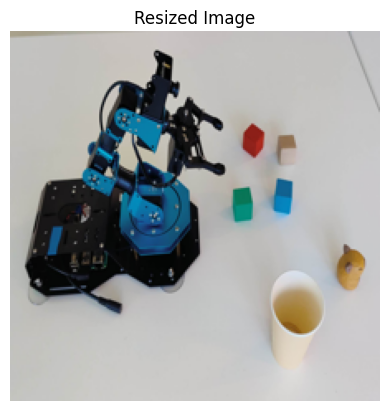

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x7265F7FFACF0>], videos: None
system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in details:
assistant
The image shows a robotic arm with a blue and black body, positioned on the left side of the table. The robotic arm is equipped with multiple joints and grippers, suggesting it is designed for precise manipulation tasks.

To the right of the robotic arm, there is a white plastic cup placed near the center of the table. Next to the cup, there is a small wooden object that appears to be a toy or a piece of furniture. 

In front of these items, there are several colorful blocks arranged in a row. These blocks come in various colors including red, green, blue, yellow, and brown. They appear to be made of foam or a similar material and are likely used for educational purposes, such as teaching children about colors or spatial relationsh

In [2]:
def inference_img(img_path, 
                system_prompt="You are a helpful assistant that can understand images and answer questions.", 
                user_prompt="Describe objects and their relative locations in details: ",
                resize_location="resized.jpg",
                resieze_size=(224, 224)):
    img_path = img_path
    image = Image.open(img_path).convert("RGB")
    image = image.resize(resieze_size) 
    image.save(resize_location)
    
    # plot resized image
    plt.imshow(image)
    plt.axis('off')  # 去掉坐标轴
    plt.title("Resized Image")
    plt.show()
    
    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": resize_location},
                {"type": "text", "text": user_prompt}
            ],
        },
    ]

    if_return_audio = False  # 如果不涉及音频，设为 False
    # 准备推理输入
    text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
    audios, images, videos = process_mm_info(conversation, use_audio_in_video=if_return_audio)
    print(f"audios: {audios}, images: {images}, videos: {videos}")
    inputs = processor(
        text=text,
        audio=audios,
        images=images,
        videos=videos,
        return_tensors="pt",
        padding=True,
        use_audio_in_video=if_return_audio,
    )
    inputs = inputs.to(model.device).to(model.dtype)

    text_ids = model.generate(
        **inputs,
        use_audio_in_video=if_return_audio,           # 不启用音频
        return_audio=False,                 # 不返回音频
        # max_new_tokens=50,                # 限制输出长度
        # max_length=10, 
        do_sample=True,                     # 采样生成（非贪心）
        temperature=0.5,                    # 控制多样性
        top_p=0.9,                          # nucleus sampling
        repetition_penalty=1.1              # 减少重复输出
    )


    output_text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print(output_text)
    
inference_img(img_path="../img/img1.jpg", user_prompt="Describe objects and their relative locations in details:")

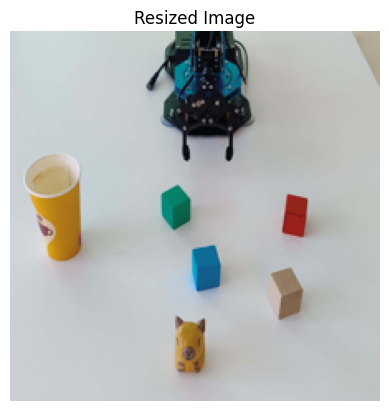

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x7265F7F73C50>], videos: None
system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in details: 
assistant
In the image, there is a small table with various objects arranged on it. The objects include:

1. A yellow toy figure located towards the bottom center of the image.
2. A blue block positioned near the yellow toy figure.
3. A red block situated slightly to the right of the blue block.
4. A green block placed further to the left of the blue block.
5. A light blue block located between the green and red blocks.
6. A dark blue cup on the far left side of the image.

The arrangement of these objects suggests they might be part of an educational or play activity involving shapes and colors. The objects are spread out across the table, creating a visually engaging scene.


In [3]:
inference_img(img_path="../img/img2.jpg")

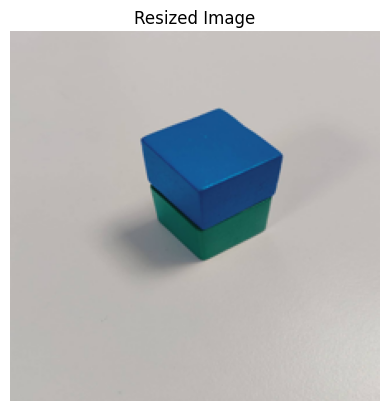

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x7265F7F1FD90>], videos: None
system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in details: 
assistant
In the image, there is a simple geometric scene featuring two cubes placed on a flat surface with a neutral background.

1. **Foreground Cube**:
   - The cube in the foreground is colored blue.
   - It has a slightly glossy or reflective surface, giving it a smooth appearance.
   - This cube appears to be positioned upright, with its top face facing upwards.

2. **Background Cube**:
   - Behind the blue cube, there is another cube.
   - This cube is colored green.
   - Like the blue cube, it also has a glossy or reflective surface.
   - The green cube is oriented similarly to the blue one, with its top face facing upwards.

3. **Surface and Background**:
   - Both cubes rest on a flat, light-colored surface, likely white or off-wh

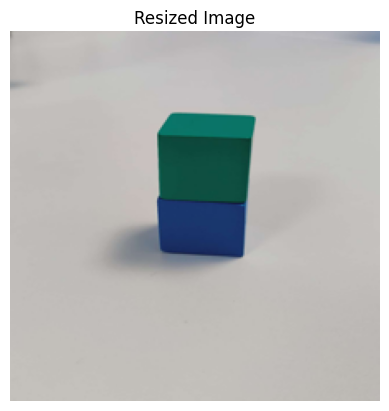

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x7265FC1EC730>], videos: None
system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in details: 
assistant
The image shows two cubes stacked on top of each other. The top cube is green, while the bottom cube is blue. Both cubes have a matte finish and appear to be made of a uniform material. They are positioned against a plain white background with no additional elements or context provided.


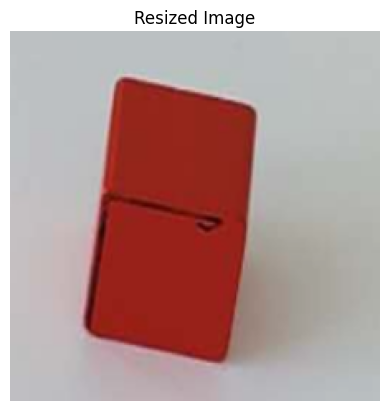

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x7265FC1453B0>], videos: None
system
You are a helpful assistant that can understand images and answer questions.
user
Describe objects and their relative locations in details: 
assistant
The image shows a small, rectangular object with rounded edges. The object appears to be metallic or made of a similar reflective material. It has a red hue on one side and a lighter color on the other side, suggesting it might be a piece of jewelry or an accessory such as a keychain or pendant.

- **Red Side**: This side is more prominent and has a smooth, polished surface. There is a small, indented area near the top center, which could be a design element or a functional feature like a clip.
  
- **Lighter Side**: This side is less reflective compared to the red side but still maintains some shine. It has a slightly darker shade of red and does not have any visible indentations or designs.

The background of the image is plain 

In [4]:
inference_img(img_path="../img/BlueUp1.jpg")
inference_img(img_path="../img/GreenUp1.jpg")
inference_img(img_path="../img/red cube.png")

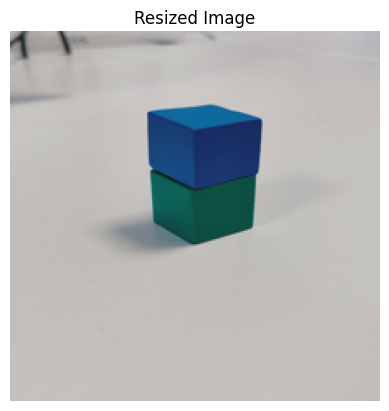

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x7265F7F19DB0>], videos: None
system
You are a helpful assistant that can understand images and answer questions.
user
Identify the green object and describe its position. If any objects are blocking the path for a robotic arm to grasp it, provide a step-by-step strategy to remove or relocate the obstacles. Then, describe how the robotic arm should pick up the green object safely.
assistant
The green object is located at coordinates (74, 86) in the image. The blue cube is blocking the path for the robotic arm to reach the green object directly.

Step 1: Move the blue cube slightly upwards.
Step 2: Once the blue cube is out of the way, move the robotic arm towards the green object.
Step 3: When the robotic arm is close enough, use a gentle grip to lift the green object without causing any damage.

By following these steps, the green object can be safely picked up by the robotic arm.


In [10]:
user_prompt = (
    "Identify the green object and describe its position. "
    "If any objects are blocking the path for a robotic arm to grasp it, "
    "provide a step-by-step strategy to remove or relocate the obstacles. "
    "Then, describe how the robotic arm should pick up the green object safely."
)

inference_img(img_path="../img/BlueUp2.jpg",user_prompt =user_prompt) 

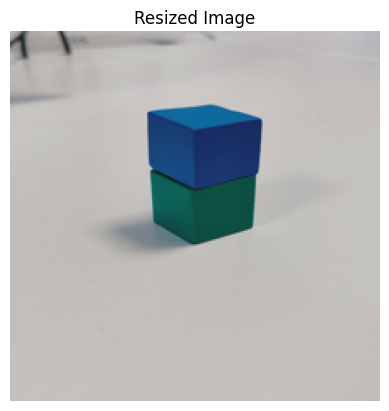

audios: None, images: [<PIL.Image.Image image mode=RGB size=224x224 at 0x7265F7F88550>], videos: None
system
You are a helpful assistant that can understand images and answer questions.
user
Identify the green object and describe its environments. If any objects are blocking the path for a robotic arm to grasp it, provide a step-by-step strategy to pick up the green object safely.
assistant
The green object is a cube located on top of another cube. It is positioned on a flat surface with no visible obstacles in front of it.

To safely pick up the green object using a robotic arm:
1. **Position the robot near the green object**: Ensure the robot's grippers are within reach.
2. **Use a suction cup or vacuum gripper**: This type of gripper is gentle and does not damage delicate surfaces.
3. **Apply pressure slowly**: Start by applying light pressure to ensure the green object is securely grasped without causing it to fall off.
4. **Adjust the position if necessary**: Use rotational moveme

In [11]:
user_prompt = (
    "Identify the green object and describe its environments. "
    "If any objects are blocking the path for a robotic arm to grasp it, "
    "provide a step-by-step strategy to pick up the green object safely."
)

inference_img(img_path="../img/BlueUp2.jpg",user_prompt =user_prompt) 

In [ ]:
# img_path = "../img/BlueUp5.jpg"
# image = Image.open(img_path).convert("RGB")
# image = image.resize((224, 224))  # 或者 (384, 384)
# image.save("resized.jpg")

# conversation = [
#     {
#         "role": "system",
#         "content": [{"type": "text", "text": "You are a helpful assistant that can understand images and answer questions."}],
#     },
#     {
#         "role": "user",
#         "content": [
#             {"type": "image", "image": "resized.jpg"},
#             {"type": "text", "text": "Descirbe objects and their relative locations in details: "}
#         ],
#     },
# ]


# # 如果不涉及音频，设为 False
# USE_AUDIO_IN_VIDEO = False

# # 准备推理输入
# text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
# audios, images, videos = process_mm_info(conversation, use_audio_in_video=USE_AUDIO_IN_VIDEO)
# inputs = processor(
#     text=text,
#     audio=audios,
#     images=images,
#     videos=videos,
#     return_tensors="pt",
#     padding=True,
#     use_audio_in_video=USE_AUDIO_IN_VIDEO,
# )
# inputs = inputs.to(model.device).to(model.dtype)

# # 推理（仅生成文字，无需语音时可不保存 audio）
# # text_ids, _ = model.generate(**inputs, use_audio_in_video=USE_AUDIO_IN_VIDEO)

# text_ids = model.generate(
#     **inputs,
#     use_audio_in_video=False,           # 不启用音频
#     return_audio=False, # 不返回音频
#     # max_new_tokens=20,                  # 限制输出长度
#     do_sample=True,                     # 采样生成（非贪心）
#     temperature=0.7,                    # 控制多样性
#     top_p=0.9,                          # nucleus sampling
#     repetition_penalty=1.1             # 减少重复输出
# )


# output_text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
# print(output_text)